In [11]:
#Lab2.3

import cv2
import numpy as np
from matplotlib import pyplot as plt

In [12]:
def calculate_lookup(src_cdf, ref_cdf):
    """
    method เอาไว้เปรียบเทียบค่า cdf เพื่อแปลงสีตาม template
    """
    lookup_table = np.zeros(256)
    lookup_val = 0
    for src_pixel_val in range(len(src_cdf)):
        lookup_val
        for ref_pixel_val in range(len(ref_cdf)):
            if ref_cdf[ref_pixel_val] >= src_cdf[src_pixel_val]:
                lookup_val = ref_pixel_val
                break
        lookup_table[src_pixel_val] = lookup_val
    return lookup_table

In [13]:
'''
    Matching() : เอาไว้เปรียบเทียบค่า cdf เพื่อที่จะนำไปสร้างภาพใหม่ที่นำสีมาจาก template หลังจากนั้นก็ทำการ merge RGB รวมกันให้กลายเป็นภาพใหม่ภาพเดียว
'''
def Matching(ori_red,ori_green,ori_blue,temp_red,temp_green,temp_blue,r,g,b):
    look_r = calculate_lookup(ori_red,temp_red)
    look_g = calculate_lookup(ori_green,temp_green)
    look_b = calculate_lookup(ori_blue,temp_blue)
    
    tranform_red = cv2.LUT(r,look_r)
    tranform_green = cv2.LUT(g,look_g)
    tranform_blue = cv2.LUT(b,look_b)
    
    matchImage = cv2.merge([tranform_red,tranform_green,tranform_blue])
    matchImage = cv2.convertScaleAbs(matchImage)
    
    return matchImage

<<------------------------------ORIGINAL------------------------------>>
Last CDF Red Original: 0.9999999999999999
Last CDF Green Original: 1.0000000000000004
Last CDF Blue Original: 1.0000000000000004
Last CDF Red is close to 1.0
Last CDF Green is close to 1.0
Last CDF Blue is close to 1.0
<<------------------------------TEMPLATE------------------------------>>
Last CDF Red: 0.9649493446007594
Last CDF Green: 0.9649493446007582
Last CDF Blue: 0.9649493446007588
Last CDF Red is close to 1.0
Last CDF Green is close to 1.0
Last CDF Blue is close to 1.0
<<--------------------------------Match-------------------------------->>
Last CDF Red: 1.0
Last CDF Green: 1.0000000000000002
Last CDF Blue: 1.0
Last CDF Red is close to 1.0
Last CDF Green is close to 1.0
Last CDF Blue is close to 1.0


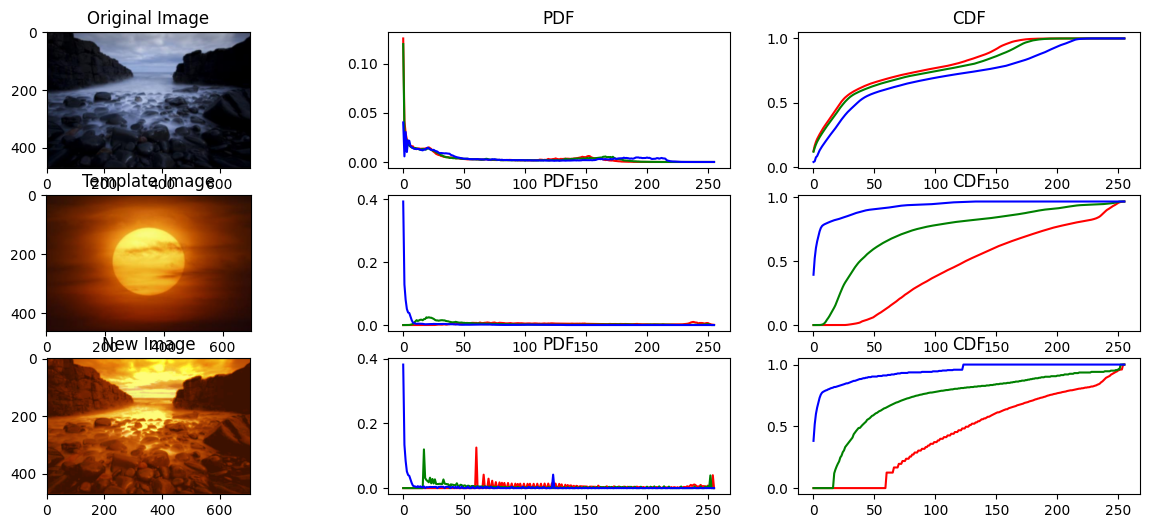

In [14]:
# อ่านภาพเข้ามา 2 ภาพ
original_img = cv2.imread("test1.png")
template_img = cv2.imread("test2.png")

# convert สีของภาพจาก BGR to RGB ทั้ง 2 ภาพ
original_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
template_rgb = cv2.cvtColor(template_img, cv2.COLOR_BGR2RGB)

# แยกช่องสี R, G, B
ori_r, ori_g, ori_b = cv2.split(original_rgb)

"""
    คำนวณ Histogram ของแต่ละช่องสีของ original_img, template_img 
    โดยใช้ cv2.calCHist()
"""
hist_ro = cv2.calcHist([original_rgb], [0], None, [256], [0, 256])
hist_go = cv2.calcHist([original_rgb], [1], None, [256], [0, 256])
hist_bo = cv2.calcHist([original_rgb], [2], None, [256], [0, 256])

hist_rt = cv2.calcHist([template_rgb], [0], None, [256], [0, 256])
hist_gt = cv2.calcHist([template_rgb], [1], None, [256], [0, 256])
hist_bt = cv2.calcHist([template_rgb], [2], None, [256], [0, 256])

total_pixels = original_rgb.shape[0] * original_rgb.shape[1]
# ทำ Normalized array ของ Histogram ของ original_img (PDF)
pdf_ro = hist_ro / total_pixels
pdf_go = hist_go / total_pixels
pdf_bo = hist_bo / total_pixels
# ทำ Normalized array ของ Histogram ของ template_img (PDF)
pdf_rt = hist_rt / total_pixels
pdf_gt = hist_gt / total_pixels
pdf_bt = hist_bt / total_pixels

"""
    คำนวณ Cumulative Distribution Function (CDF) ของ original_img, template_img 
    โดยจะใช้ np.cumsum() ในการคำนวณ CDF โดยการนำ PDF ใน array แต่ละค่ามาบวกกันเรื่อย ๆ จากด้าน
    ซ้ายไปด้านขวาตั้งแต่ต้นถึงจุดปัจจุบันในลำดับ
"""
cdf_ro = np.cumsum(pdf_ro)
cdf_go = np.cumsum(pdf_go)
cdf_bo = np.cumsum(pdf_bo)

cdf_rt = np.cumsum(pdf_rt)
cdf_gt = np.cumsum(pdf_gt)
cdf_bt = np.cumsum(pdf_bt)

# เรียกใช้ function Matching
matchImage = Matching(cdf_ro,cdf_go,cdf_bo,cdf_rt,cdf_gt,cdf_bt,ori_r,ori_g,ori_b)

# คำนวณ Histogram, PDF, CDF ของแต่ละช่องสีของ match_img
hist_rm = cv2.calcHist([matchImage], [0], None, [256], [0, 256])
hist_gm = cv2.calcHist([matchImage], [1], None, [256], [0, 256])
hist_bm = cv2.calcHist([matchImage], [2], None, [256], [0, 256])

pdf_rm = hist_rm / total_pixels
pdf_gm = hist_gm / total_pixels
pdf_bm = hist_bm / total_pixels

cdf_rm = np.cumsum(pdf_rm)
cdf_gm = np.cumsum(pdf_gm)
cdf_bm = np.cumsum(pdf_bm)
    
# แสดงภาพบน subplot
fig, axes = plt.subplots(3, 3, figsize=(15, 6))

axes[0,0].imshow(original_rgb)
axes[0,0].set_title('Original Image')

axes[0,1].plot(pdf_ro, color='r')
axes[0,1].plot(pdf_go, color='g')
axes[0,1].plot(pdf_bo, color='b')
axes[0,1].set_title('PDF')

axes[0,2].plot(cdf_ro, color='r')
axes[0,2].plot(cdf_go, color='g')
axes[0,2].plot(cdf_bo, color='b')
axes[0,2].set_title('CDF')

axes[1,0].imshow(template_rgb)
axes[1,0].set_title('Template Image')

axes[1,1].plot(pdf_rt, color='r')
axes[1,1].plot(pdf_gt, color='g')
axes[1,1].plot(pdf_bt, color='b')
axes[1,1].set_title('PDF')

axes[1,2].plot(cdf_rt, color='r')
axes[1,2].plot(cdf_gt, color='g')
axes[1,2].plot(cdf_bt, color='b')
axes[1,2].set_title('CDF')

axes[2,0].imshow(matchImage)
axes[2,0].set_title('New Image')

axes[2,1].plot(pdf_rm, color='r')
axes[2,1].plot(pdf_gm, color='g')
axes[2,1].plot(pdf_bm, color='b')
axes[2,1].set_title('PDF')

axes[2,2].plot(cdf_rm, color='r')
axes[2,2].plot(cdf_gm, color='g')
axes[2,2].plot(cdf_bm, color='b')
axes[2,2].set_title('CDF')

# แสดงผลค่า CDF ในตำแหน่งสุดท้าย
print("<<------------------------------ORIGINAL------------------------------>>")
print("Last CDF Red Original:", cdf_ro[-1])
print("Last CDF Green Original:", cdf_go[-1])
print("Last CDF Blue Original:", cdf_bo[-1])

# ตรวจสอบว่า cdf ค่าสุดท้ายใกล้เคียง 1.0 มั้ย
if abs(1-cdf_ro[-1]) <= 0.1:
    print("Last CDF Red is close to 1.0")
if abs(1-cdf_go[-1]) <= 0.1:
    print("Last CDF Green is close to 1.0")
if abs(1-cdf_bo[-1]) <= 0.1:
    print("Last CDF Blue is close to 1.0")
    
# แสดงผลค่า CDF ในตำแหน่งสุดท้าย
print("<<------------------------------TEMPLATE------------------------------>>")
print("Last CDF Red:", cdf_rt[-1])
print("Last CDF Green:", cdf_gt[-1])
print("Last CDF Blue:", cdf_bt[-1])

# ตรวจสอบว่า cdf ค่าสุดท้ายใกล้เคียง 1.0 มั้ย
if abs(1-cdf_rt[-1]) <= 0.1:
    print("Last CDF Red is close to 1.0")
if abs(1-cdf_gt[-1]) <= 0.1:
    print("Last CDF Green is close to 1.0")
if abs(1-cdf_bt[-1]) <= 0.1:
    print("Last CDF Blue is close to 1.0")
    
# แสดงผลค่า CDF ในตำแหน่งสุดท้าย
print("<<--------------------------------Match-------------------------------->>")
print("Last CDF Red:", cdf_rm[-1])
print("Last CDF Green:", cdf_gm[-1])
print("Last CDF Blue:", cdf_bm[-1])

# ตรวจสอบว่า cdf ค่าสุดท้ายใกล้เคียง 1.0 มั้ย
if abs(1-cdf_rm[-1]) <= 0.1:
    print("Last CDF Red is close to 1.0")
if abs(1-cdf_gm[-1]) <= 0.1:
    print("Last CDF Green is close to 1.0")
if abs(1-cdf_bm[-1]) <= 0.1:
    print("Last CDF Blue is close to 1.0")

In [15]:
# สร้างรูปภาพที่ได้หลังจากการ match ด้วย imwrite
matchImage = cv2.cvtColor(matchImage,cv2.COLOR_BGR2RGB)
cv2.imwrite('result.jpg',matchImage)

True